<a href="https://colab.research.google.com/github/DT6A/JBMAHS/blob/main/JB_MAHS_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gym

Requirement already up-to-date: gym in /usr/local/lib/python3.6/dist-packages (0.18.0)


In [ ]:
import os
import random

from collections import deque
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import gym

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
env = gym.make("MountainCar-v0")

In [ ]:
def simple_policy(obs):
  velocity = obs[1]
  return 0 if velocity < 0 else 2

In [382]:
def test_policy(enviroment, episodes_n=1000, policy=simple_policy):
  enviroment.seed(0)
  results = []
  for ep in range(episodes_n):
    total_reward = 0
    obs = enviroment.reset()
    done = False

    while not done:
      action = policy(obs)
      obs, reward, done, info = enviroment.step(action)
      total_reward += reward

    results.append(total_reward)
    enviroment.close()
  print('mean:', np.mean(results), 
        '\nstd:', np.std(results), 
        '\nmin:', np.min(results), 
        '\nmax:', np.max(results))

In [387]:
test_policy(env, 100, simple_policy)

mean: -119.41 
std: 3.591921491346937 
min: -125.0 
max: -113.0


## Policy gradient

This approach can solve CartPole easily, but have troubles with MountainCar even with reward function changes and warm up policy

In [ ]:
GAMMA = 0.99 # discount factor

In [ ]:
class MC_FNN(nn.Module):
  def __init__(self, hidden_dim=32, do_p=0.5):
    super().__init__()

    self.fc1 = nn.Linear(2, hidden_dim)
    self.do1 = nn.Dropout(do_p)
    self.act1 = nn.ELU()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.do2 = nn.Dropout(do_p)
    self.act2 = nn.ELU()
    self.fc3 = nn.Linear(hidden_dim, 3)
    self.act3 = nn.Softmax(dim=-1)

  def forward(self, X):
    X = self.fc1(X)
    X = self.do1(X)
    X = self.act1(X)
    X = self.fc2(X)
    X = self.do2(X)
    X = self.act2(X)
    X = self.fc3(X)
    return self.act3(X)

In [ ]:
class Gradient_policy():
  def __init__(self, fnn, lr=3e-3):
    self.fnn = fnn
    self.optimizer = torch.optim.Adam(fnn.parameters(), lr=lr)
    self.reset_state()
    

  def reset_state(self):
    self.rewards_history = []
    self.actions_history = torch.autograd.Variable(torch.Tensor())

  def get_action(self, obs, is_train=True):
    if not is_train:
      self.fnn.eval()
    probs = self.fnn(torch.Tensor(obs))
    distr = torch.distributions.Categorical(probs)
    action = distr.sample()

    if is_train:
      log_p = distr.log_prob(action)
      if self.actions_history.size()[0] == 0:
        self.actions_history = log_p.reshape(1)
      else:
        self.actions_history = torch.cat([self.actions_history, log_p.reshape(1)])
    else:
      self.fnn.train()

    return action

  def __call__(self, obs):
    return self.get_action(obs, False).item()


  def update(self):
    rewards_sum = 0
    discounted_rewards = []
    
    for r in self.rewards_history[::-1]:
      rewards_sum = r + GAMMA * rewards_sum
      discounted_rewards.append(rewards_sum) 

    discounted_rewards = torch.Tensor(discounted_rewards[::-1])
    norm_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-10)
    loss = torch.sum(torch.mul(self.actions_history, norm_rewards).mul(-1), -1)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.reset_state()


In [ ]:
def train_policy(policy, n_epoches=150000, max_iters=200, 
                 modify_reward=True, modification_scale=500,
                 wu_policy=simple_policy, wu_dur=110, wu_decr=1000):
  rewards = []
  for e in range(n_epoches):
    obs = env.reset()
    curr_reward = 0
    prev_state = obs
    steps = 0

    for it in range(max_iters):
      done = None

      if it < wu_dur:
        action = wu_policy(obs)
        obs, reward, done, info = env.step(action)
        curr_reward += reward
      else:
        action = policy.get_action(obs)
        obs, reward, done, info = env.step(action.item())
        if modify_reward:
          reward += modification_scale * (GAMMA * abs(obs[1]) - abs(prev_state[1]))
          prev_state = obs
        policy.rewards_history.append(reward)
        curr_reward += reward
      
      if done:
        break
      steps += 1

    policy.update()
    rewards.append(curr_reward)
    if e % 500 == 0:
      print('Epoch', e, '\tLast run length:', steps, '\tWU policy duration:', wu_dur, '\tMean reward:', np.mean(rewards))
      lens = []
    if wu_dur > 0 and (e + 1) % wu_decr == 0:
      wu_dur -= 1

In [ ]:
nn_policy = Gradient_policy(MC_FNN())

In [ ]:
train_policy(nn_policy, modify_reward=True)

Epoch 0 	Last run length: 119 	WU policy duration: 110 	Mean reward: -103.95795596416315
Epoch 500 	Last run length: 113 	WU policy duration: 110 	Mean reward: -103.34793516897909
Epoch 1000 	Last run length: 124 	WU policy duration: 109 	Mean reward: -101.72972188598993
Epoch 1500 	Last run length: 122 	WU policy duration: 109 	Mean reward: -101.23961911070421
Epoch 2000 	Last run length: 112 	WU policy duration: 108 	Mean reward: -100.81984349663881
Epoch 2500 	Last run length: 113 	WU policy duration: 108 	Mean reward: -100.56437257237192
Epoch 3000 	Last run length: 113 	WU policy duration: 107 	Mean reward: -100.4475236871968
Epoch 3500 	Last run length: 121 	WU policy duration: 107 	Mean reward: -100.41970579637668
Epoch 4000 	Last run length: 120 	WU policy duration: 106 	Mean reward: -100.35039568062305
Epoch 4500 	Last run length: 115 	WU policy duration: 106 	Mean reward: -100.3378725522021
Epoch 5000 	Last run length: 121 	WU policy duration: 105 	Mean reward: -100.294096633

KeyboardInterrupt: ignored

Many experiments were taken and PG fails to learn policy for this problem

## DQN

In [ ]:
GAMMA = 0.99 # discount factor
BATCH_SIZE = 256

In [ ]:
class MC_DQN(nn.Module):
  def __init__(self, hidden_dim=32, use_norm=False):
    super().__init__()

    self.use_norm = use_norm

    self.fc1 = nn.Linear(2, hidden_dim)
    if use_norm:
      self.norm1 = nn.LayerNorm(hidden_dim)
    self.act1 = nn.ELU()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    if use_norm:
      self.norm2 = nn.LayerNorm(hidden_dim)
    self.act2 = nn.ELU()
    self.fc3 = nn.Linear(hidden_dim, 3)


  def forward(self, X):
    X = self.fc1(X)
    if self.use_norm:
      X = self.norm1(X)
    X = self.act1(X)
    X = self.fc2(X)
    if self.use_norm:
      X = self.norm2(X)
    X = self.act2(X)
    X = self.fc3(X)
    return X

In [ ]:
class Memmory():
  def __init__(self, capacity=5000):
    self.capacity = capacity
    self.storage = deque([], maxlen=capacity)


  def add(self, data):
    self.storage.append(data)


  def sample(self, batch_size):
    obs, actions, rewards, new_obs, done = [], [], [], [], []

    ind = np.random.permutation(len(self.storage))[:batch_size]

    for i in ind:
      sample = self.storage[i]
      
      obs.append(sample[0])
      actions.append(sample[1])
      rewards.append(sample[2])
      new_obs.append(sample[3])
      done.append(sample[4])
      
    return obs, actions, rewards, new_obs, done

  def __len__(self):
    return len(self.storage)

In [ ]:
class DQN_policy():
  def __init__(self, fnn, lr=1e-4, copy_intervals=1000,
               mem_size=5000,
               eps_max=0.5, eps_min=0.1, eps_decay_steps=100000):
    self.online_dqn = fnn
    self.target_dqn = deepcopy(fnn)
    self.target_dqn.eval()

    self.optimizer = torch.optim.Adam(self.online_dqn.parameters(), lr=lr)

    self.mem = Memmory(mem_size)

    self.copy_intervals = copy_intervals
    self.eps_max = eps_max
    self.eps_min = eps_min
    self.eps_decay = eps_decay_steps
    self.step = 0

    self.log_rewards = []

  def get_action(self, obs, eps, dqn):
    if random.random() < eps:
      return random.randint(0, 2)
    else:
      out = dqn(torch.Tensor(obs))
      return torch.argmax(out).item()


  def __call__(self, obs):
    return self.get_action(obs, 0, self.target_dqn)


  def update(self):
      obs, actions, rewards, new_obs, done = self.mem.sample(BATCH_SIZE)

      obs = torch.FloatTensor(obs)
      actions = torch.tensor(actions)
      rewards = torch.FloatTensor(rewards)
      new_obs = torch.FloatTensor(new_obs)
      done = torch.tensor(done)

      target_q = None
      with torch.no_grad():
        target_q = torch.max(self.target_dqn(new_obs), 1)[0]
        target_q[done] = 0
      target_q = (rewards + GAMMA * target_q).unsqueeze(1)

      pred_q =  self.online_dqn(obs)
      pred_q = torch.gather(pred_q, 1, actions.unsqueeze(1))
      criterion = nn.MSELoss()
      loss = criterion(target_q, pred_q)

      self.optimizer.zero_grad()
      loss.backward()
      for param in self.online_dqn.parameters():
        param.grad.data.clamp_(-1, 1)
      self.optimizer.step()


  def train(self, evniroment, n_steps=100000, 
            modify_reward=True, reward_modif_scale=300):
    obs = evniroment.reset()
    for s in range(n_steps): 
      eps = max(self.eps_min, self.eps_max - self.eps_min * self.step / self.eps_decay)     
      action = self.get_action(obs, eps, self.online_dqn)
      new_obs, reward, done, _ = evniroment.step(action)

      if modify_reward:
        reward += reward_modif_scale * (GAMMA * abs(new_obs[1]) - abs(obs[1]))

      self.mem.add((obs, action, reward, new_obs, done))

      obs = evniroment.reset() if done else new_obs

      self.update()

      if self.step % self.copy_intervals == 0:
          self.target_dqn = deepcopy(self.online_dqn)
          self.target_dqn.eval()

          obs = evniroment.reset()
          done = False
          obtained_reward = 0

          while not done:
            action = self.get_action(obs, 0, self.target_dqn)
            obs, reward, done, _ = evniroment.step(action)
            obtained_reward += reward

          self.log_rewards.append(obtained_reward)
          print('Step', self.step, '\treward:', obtained_reward)

      self.step += 1

In [ ]:
dqn_policy = DQN_policy(MC_DQN())

In [ ]:
dqn_policy.train(env, 150000)

Step 0 	reward: -200.0
Step 1000 	reward: -200.0
Step 2000 	reward: -200.0
Step 3000 	reward: -200.0
Step 4000 	reward: -200.0
Step 5000 	reward: -170.0
Step 6000 	reward: -138.0
Step 7000 	reward: -136.0
Step 8000 	reward: -176.0
Step 9000 	reward: -141.0
Step 10000 	reward: -136.0
Step 11000 	reward: -137.0
Step 12000 	reward: -139.0
Step 13000 	reward: -181.0
Step 14000 	reward: -186.0
Step 15000 	reward: -179.0
Step 16000 	reward: -135.0
Step 17000 	reward: -140.0
Step 18000 	reward: -109.0
Step 19000 	reward: -113.0
Step 20000 	reward: -116.0
Step 21000 	reward: -142.0
Step 22000 	reward: -112.0
Step 23000 	reward: -199.0
Step 24000 	reward: -110.0
Step 25000 	reward: -159.0
Step 26000 	reward: -159.0
Step 27000 	reward: -111.0
Step 28000 	reward: -111.0
Step 29000 	reward: -100.0
Step 30000 	reward: -156.0
Step 31000 	reward: -132.0
Step 32000 	reward: -106.0
Step 33000 	reward: -106.0
Step 34000 	reward: -107.0
Step 35000 	reward: -110.0
Step 36000 	reward: -112.0
Step 37000 	re

In [ ]:
test_policy(env, 100, dqn_policy)

mean: -128.57 
std: 28.60778041023106 
min: -186.0 
max: -84.0


In [ ]:
dqn_policy = DQN_policy(MC_DQN())

In [ ]:
dqn_policy.traina(env, 150001, reward_modif_scale=500)

Step 0 	reward: -200.0
Step 1000 	reward: -200.0
Step 2000 	reward: -200.0
Step 3000 	reward: -200.0
Step 4000 	reward: -200.0
Step 5000 	reward: -200.0
Step 6000 	reward: -156.0
Step 7000 	reward: -158.0
Step 8000 	reward: -200.0
Step 9000 	reward: -200.0
Step 10000 	reward: -149.0
Step 11000 	reward: -200.0
Step 12000 	reward: -139.0
Step 13000 	reward: -139.0
Step 14000 	reward: -133.0
Step 15000 	reward: -138.0
Step 16000 	reward: -137.0
Step 17000 	reward: -136.0
Step 18000 	reward: -137.0
Step 19000 	reward: -175.0
Step 20000 	reward: -172.0
Step 21000 	reward: -142.0
Step 22000 	reward: -148.0
Step 23000 	reward: -142.0
Step 24000 	reward: -142.0
Step 25000 	reward: -87.0
Step 26000 	reward: -148.0
Step 27000 	reward: -139.0
Step 28000 	reward: -95.0
Step 29000 	reward: -145.0
Step 30000 	reward: -91.0
Step 31000 	reward: -152.0
Step 32000 	reward: -146.0
Step 33000 	reward: -87.0
Step 34000 	reward: -138.0
Step 35000 	reward: -106.0
Step 36000 	reward: -135.0
Step 37000 	reward

In [ ]:
test_policy(env, 100, dqn_policy)

mean: -129.85 
std: 32.733583671819375 
min: -191.0 
max: -83.0


In [ ]:
dqn_policy = DQN_policy(MC_DQN(), eps_min=0.2)

In [ ]:
dqn_policy.train(env, 110001)

Step 0 	reward: -200.0
Step 1000 	reward: -200.0
Step 2000 	reward: -200.0
Step 3000 	reward: -200.0
Step 4000 	reward: -200.0
Step 5000 	reward: -200.0
Step 6000 	reward: -200.0
Step 7000 	reward: -200.0
Step 8000 	reward: -200.0
Step 9000 	reward: -200.0
Step 10000 	reward: -141.0
Step 11000 	reward: -138.0
Step 12000 	reward: -134.0
Step 13000 	reward: -135.0
Step 14000 	reward: -142.0
Step 15000 	reward: -192.0
Step 16000 	reward: -143.0
Step 17000 	reward: -115.0
Step 18000 	reward: -110.0
Step 19000 	reward: -141.0
Step 20000 	reward: -143.0
Step 21000 	reward: -200.0
Step 22000 	reward: -113.0
Step 23000 	reward: -144.0
Step 24000 	reward: -143.0
Step 25000 	reward: -116.0
Step 26000 	reward: -200.0
Step 27000 	reward: -116.0
Step 28000 	reward: -153.0
Step 29000 	reward: -153.0
Step 30000 	reward: -148.0
Step 31000 	reward: -159.0
Step 32000 	reward: -161.0
Step 33000 	reward: -154.0
Step 34000 	reward: -156.0
Step 35000 	reward: -150.0
Step 36000 	reward: -164.0
Step 37000 	re

In [ ]:
test_policy(env, 100, dqn_policy)

mean: -118.13 
std: 20.087137675637113 
min: -191.0 
max: -109.0


In [ ]:
dqn_policy.train(env, 15000)

Step 111000 	reward: -109.0
Step 112000 	reward: -113.0
Step 113000 	reward: -110.0
Step 114000 	reward: -111.0
Step 115000 	reward: -112.0
Step 116000 	reward: -120.0
Step 117000 	reward: -200.0
Step 118000 	reward: -110.0
Step 119000 	reward: -109.0
Step 120000 	reward: -138.0
Step 121000 	reward: -111.0
Step 122000 	reward: -111.0
Step 123000 	reward: -110.0
Step 124000 	reward: -111.0
Step 125000 	reward: -109.0


In [ ]:
test_policy(env, 100, dqn_policy)

mean: -116.19 
std: 18.255243082468116 
min: -184.0 
max: -107.0


In [ ]:
dqn_policy = DQN_policy(MC_DQN(), mem_size=2500)

In [ ]:
dqn_policy.train(env, 110001)

Step 0 	reward: -200.0
Step 1000 	reward: -200.0
Step 2000 	reward: -200.0
Step 3000 	reward: -136.0
Step 4000 	reward: -136.0
Step 5000 	reward: -200.0
Step 6000 	reward: -141.0
Step 7000 	reward: -135.0
Step 8000 	reward: -136.0
Step 9000 	reward: -135.0
Step 10000 	reward: -108.0
Step 11000 	reward: -108.0
Step 12000 	reward: -137.0
Step 13000 	reward: -141.0
Step 14000 	reward: -144.0
Step 15000 	reward: -138.0
Step 16000 	reward: -141.0
Step 17000 	reward: -141.0
Step 18000 	reward: -109.0
Step 19000 	reward: -141.0
Step 20000 	reward: -137.0
Step 21000 	reward: -135.0
Step 22000 	reward: -135.0
Step 23000 	reward: -87.0
Step 24000 	reward: -140.0
Step 25000 	reward: -159.0
Step 26000 	reward: -148.0
Step 27000 	reward: -147.0
Step 28000 	reward: -153.0
Step 29000 	reward: -163.0
Step 30000 	reward: -200.0
Step 31000 	reward: -141.0
Step 32000 	reward: -140.0
Step 33000 	reward: -143.0
Step 34000 	reward: -108.0
Step 35000 	reward: -165.0
Step 36000 	reward: -107.0
Step 37000 	rew

Almost solved. Some hyper-parameters tuning should help to reach mean score $\ge -110$

In [ ]:
test_policy(env, 100, dqn_policy)

mean: -112.41 
std: 1.749828563031247 
min: -117.0 
max: -111.0


In [ ]:
dqn_policy = DQN_policy(MC_DQN(50), mem_size=2500)

In [ ]:
dqn_policy.train(env, 110001)

Step 0 	reward: -200.0
Step 1000 	reward: -200.0
Step 2000 	reward: -200.0
Step 3000 	reward: -181.0
Step 4000 	reward: -167.0
Step 5000 	reward: -138.0
Step 6000 	reward: -109.0
Step 7000 	reward: -137.0
Step 8000 	reward: -107.0
Step 9000 	reward: -176.0
Step 10000 	reward: -142.0
Step 11000 	reward: -142.0
Step 12000 	reward: -153.0
Step 13000 	reward: -145.0
Step 14000 	reward: -146.0
Step 15000 	reward: -145.0
Step 16000 	reward: -144.0
Step 17000 	reward: -158.0
Step 18000 	reward: -147.0
Step 19000 	reward: -83.0
Step 20000 	reward: -160.0
Step 21000 	reward: -139.0
Step 22000 	reward: -143.0
Step 23000 	reward: -138.0
Step 24000 	reward: -140.0
Step 25000 	reward: -110.0
Step 26000 	reward: -108.0
Step 27000 	reward: -140.0
Step 28000 	reward: -109.0
Step 29000 	reward: -107.0
Step 30000 	reward: -132.0
Step 31000 	reward: -132.0
Step 32000 	reward: -136.0
Step 33000 	reward: -109.0
Step 34000 	reward: -142.0
Step 35000 	reward: -114.0
Step 36000 	reward: -111.0
Step 37000 	rew

In [ ]:
test_policy(env, 100, dqn_policy)

mean: -120.26 
std: 22.97939076651076 
min: -200.0 
max: -84.0


### MountainCar-v0 solved

In [ ]:
dqn_policy = DQN_policy(MC_DQN(use_norm=True), mem_size=2500)

In [ ]:
dqn_policy.train(env, 110001)

Step 0 	reward: -200.0
Step 1000 	reward: -200.0
Step 2000 	reward: -200.0
Step 3000 	reward: -165.0
Step 4000 	reward: -141.0
Step 5000 	reward: -169.0
Step 6000 	reward: -148.0
Step 7000 	reward: -110.0
Step 8000 	reward: -141.0
Step 9000 	reward: -140.0
Step 10000 	reward: -172.0
Step 11000 	reward: -131.0
Step 12000 	reward: -137.0
Step 13000 	reward: -110.0
Step 14000 	reward: -143.0
Step 15000 	reward: -140.0
Step 16000 	reward: -141.0
Step 17000 	reward: -183.0
Step 18000 	reward: -200.0
Step 19000 	reward: -136.0
Step 20000 	reward: -192.0
Step 21000 	reward: -200.0
Step 22000 	reward: -200.0
Step 23000 	reward: -200.0
Step 24000 	reward: -200.0
Step 25000 	reward: -188.0
Step 26000 	reward: -200.0
Step 27000 	reward: -200.0
Step 28000 	reward: -154.0
Step 29000 	reward: -151.0
Step 30000 	reward: -146.0
Step 31000 	reward: -152.0
Step 32000 	reward: -113.0
Step 33000 	reward: -165.0
Step 34000 	reward: -200.0
Step 35000 	reward: -162.0
Step 36000 	reward: -166.0
Step 37000 	re

In [ ]:
test_policy(env, 100, dqn_policy)

mean: -119.54 
std: 33.30478043764889 
min: -200.0 
max: -84.0


In [ ]:
dqn_policy.train(env, 20001)

Step 111000 	reward: -159.0
Step 112000 	reward: -84.0
Step 113000 	reward: -144.0
Step 114000 	reward: -87.0
Step 115000 	reward: -160.0
Step 116000 	reward: -92.0
Step 117000 	reward: -92.0
Step 118000 	reward: -145.0
Step 119000 	reward: -85.0
Step 120000 	reward: -101.0
Step 121000 	reward: -85.0
Step 122000 	reward: -150.0
Step 123000 	reward: -189.0
Step 124000 	reward: -147.0
Step 125000 	reward: -159.0
Step 126000 	reward: -148.0
Step 127000 	reward: -180.0
Step 128000 	reward: -113.0
Step 129000 	reward: -153.0
Step 130000 	reward: -156.0


In [ ]:
dqn_policy.train(env, 30001)

Step 131000 	reward: -95.0
Step 132000 	reward: -103.0
Step 133000 	reward: -166.0
Step 134000 	reward: -105.0
Step 135000 	reward: -89.0
Step 136000 	reward: -109.0
Step 137000 	reward: -200.0
Step 138000 	reward: -110.0
Step 139000 	reward: -121.0
Step 140000 	reward: -110.0
Step 141000 	reward: -109.0
Step 142000 	reward: -114.0
Step 143000 	reward: -200.0
Step 144000 	reward: -113.0
Step 145000 	reward: -113.0
Step 146000 	reward: -119.0
Step 147000 	reward: -112.0
Step 148000 	reward: -112.0
Step 149000 	reward: -118.0
Step 150000 	reward: -114.0
Step 151000 	reward: -117.0
Step 152000 	reward: -118.0
Step 153000 	reward: -118.0
Step 154000 	reward: -85.0
Step 155000 	reward: -113.0
Step 156000 	reward: -113.0
Step 157000 	reward: -111.0
Step 158000 	reward: -111.0
Step 159000 	reward: -84.0
Step 160000 	reward: -107.0


In [ ]:
test_policy(env, 100, dqn_policy)

mean: -101.9 
std: 8.892131353055914 
min: -110.0 
max: -83.0


In [ ]:
dqn_policy.train(env, 10001)

Step 161000 	reward: -110.0
Step 162000 	reward: -107.0
Step 163000 	reward: -86.0
Step 164000 	reward: -108.0
Step 165000 	reward: -98.0
Step 166000 	reward: -109.0
Step 167000 	reward: -108.0
Step 168000 	reward: -107.0
Step 169000 	reward: -107.0
Step 170000 	reward: -89.0


In [ ]:
test_policy(env, 100, dqn_policy)

mean: -102.01 
std: 7.431682178349663 
min: -108.0 
max: -84.0


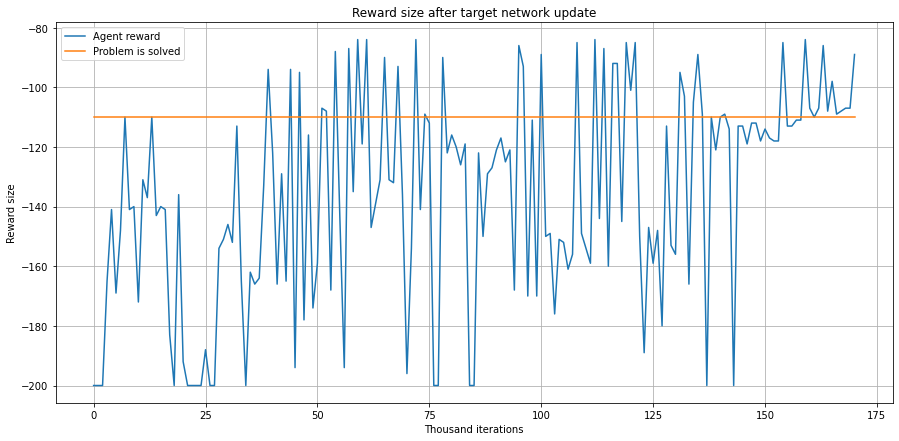

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Reward size after target network update')
plt.xlabel('Thousand iterations')
plt.ylabel('Reward size')
plt.grid()
plt.plot(np.arange(0, len(dqn_policy.log_rewards)), dqn_policy.log_rewards,
         label='Agent reward')
plt.plot(np.arange(0, len(dqn_policy.log_rewards)), 
         [-110] * len(dqn_policy.log_rewards), label='Problem is solved')
plt.legend()
plt.show()

## Actor-Critic

In [ ]:
env2 = gym.make("MountainCarContinuous-v0")

In [ ]:
env2.action_space

Box(-1.0, 1.0, (1,), float32)

In [ ]:
env2.action_space.shape, env2.observation_space.shape

((1,), (2,))

In [ ]:
def simple_continious_policy(obs):
  velocity = obs[1]
  return [-1.0] if velocity < 0 else [1.0]

In [ ]:
test_policy(env2, 100, simple_continious_policy)

mean: 89.35300000000002 
std: 0.13375724279455087 
min: 88.90000000000003 
max: 89.50000000000003


In [ ]:
GAMMA = 0.99 # discount factor
TAU = 0.05 # merging coef
ACTOR_LR = 1e-5
CRITIC_LR = 1e-5

BATCH_SIZE = 256

In [ ]:
class ActorNN(nn.Module):
  def __init__(self, hidden_dim=256):
    super().__init__()
    
    self.net = nn.Sequential(
        nn.Linear(2, hidden_dim),
        nn.LayerNorm(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LayerNorm(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1),
        nn.Tanh()
    )


  def forward(self, X):
    return self.net(X)

  
  def get_action(self, obs):
    return self.forward(torch.Tensor(obs)).detach().numpy()


class CriticNN(nn.Module):
  def __init__(self, hidden_dim=256):
    super().__init__()

    self.obs_net = nn.Sequential(
        nn.Linear(2, hidden_dim),
        nn.LayerNorm(hidden_dim),
        nn.ReLU(),
    )
    self.net = nn.Sequential(
        nn.Linear(hidden_dim + 1, hidden_dim),
        nn.LayerNorm(hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1),
    )

  def forward(self, obs, action):
    obs_v = self.obs_net(obs)
    return self.net(torch.cat([obs_v, action], dim=-1))

In [ ]:
class OUNoise():
    def __init__(self):
        self.theta = 0.15
        self.sigma = 0.6
        self.action_dim = 1
        self.low = -1
        self.high = 1
        self.eps_max = 1.0
        self.eps_min = 0.1
        self.eps = self.eps_max
        self.eps_decay = (self.eps_max - self.eps_min) / 40
        self.state = np.zeros(self.action_dim)


    def eps_step(self):
        self.eps -= self.eps_decay
        self.eps = max(self.eps, self.eps_min)


    def __call__(self, action):
        self.state += - self.theta * self.state + self.sigma * np.random.randn(self.action_dim)
        noise = self.eps * self.state
        if isinstance(action, torch.Tensor):
            return torch.clamp(action + torch.Tensor(noise).float(), self.low, self.high)
        else:
            return np.clip(action + noise, self.low, self.high)

In [ ]:
class AC_policy():
  def __init__(self, mem_size=50000):
    self.actor = ActorNN()
    self.target_actor = deepcopy(self.actor)
    self.target_actor.eval()

    self.critic = CriticNN()
    self.target_critic = deepcopy(self.critic)
    self.target_critic.eval()

    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=ACTOR_LR)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=CRITIC_LR)

    self.noise = OUNoise()
    self.mem = Memmory(mem_size)

    self.log_rewards = []


  def get_action(self, obs, net):
    return net.get_action(torch.Tensor(obs)) 


  def __call__(self, obs):
    return self.get_action(obs, self.target_actor)


  def update(self):
      obs, actions, rewards, new_obs, done = self.mem.sample(BATCH_SIZE)
      
      obs = torch.FloatTensor(obs)
      actions = torch.tensor(actions)
      rewards = torch.FloatTensor(rewards)
      new_obs = torch.FloatTensor(new_obs)
      done = torch.tensor(done)

      target_q = None
      with torch.no_grad():
        target_q = self.target_critic(new_obs, self.target_actor(new_obs))
        target_q[done] = 0
      target_q = (rewards.unsqueeze(1) + GAMMA * target_q)
      pred_q =  self.critic(obs, actions.float())
      
      critic_loss = F.mse_loss(target_q, pred_q)
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      actor_loss = self.critic(obs, self.actor(obs)).mean().mul(-1)
      self.actor_optimizer.zero_grad()
      actor_loss.backward()
      self.actor_optimizer.step()

      for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)
      for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)


  def train(self, evniroment, episodes=100, max_iters=500, 
            modify_reward=False, reward_modif_scale=300):
    for e in range(episodes): 
      obs = evniroment.reset()
      for i in range(max_iters):   
        action = self.get_action(obs, self.actor)
        action = self.noise(action)

        new_obs, reward, done, _ = evniroment.step(action)
        if modify_reward:
          reward += reward_modif_scale * (GAMMA * abs(new_obs[1]) - abs(obs[1]))
        self.mem.add((obs, action, reward, new_obs, done))

        #print('Upd')
        if len(self.mem) >= BATCH_SIZE:
          self.update()
        obs = new_obs
        if done:
          break
      
      obs = evniroment.reset()
      done = False
      obtained_reward = 0

      while not done:
        action = self.get_action(obs, self.target_actor)
        obs, reward, done, _ = evniroment.step(action)
        obtained_reward += reward

      self.log_rewards.append(obtained_reward)
      print('Episode', e, '\treward:', obtained_reward)
      self.noise.eps_step()

### MountainCarContinuous-v0 solved

In [ ]:
ac_policy = AC_policy()

In [ ]:
ac_policy.train(env2, modify_reward=False)

Episode 0 	reward: -0.9297904239524487
Episode 1 	reward: -0.029559641232551205
Episode 2 	reward: -0.06537297998924965
Episode 3 	reward: -33.94012507959498
Episode 4 	reward: -85.99037711713542
Episode 5 	reward: -97.81242257577921
Episode 6 	reward: -89.76076284305566
Episode 7 	reward: -92.6929498510757
Episode 8 	reward: -1.221269122373224
Episode 9 	reward: -36.39424052351534
Episode 10 	reward: -26.460523485337706
Episode 11 	reward: -1.3097175534103571
Episode 12 	reward: -3.391252479048636
Episode 13 	reward: -5.566954518768839
Episode 14 	reward: -1.8954414239389281
Episode 15 	reward: -17.872639190193897
Episode 16 	reward: -2.6851838246574693
Episode 17 	reward: -29.222131303799255
Episode 18 	reward: -63.24830679634443
Episode 19 	reward: -33.892001062659936
Episode 20 	reward: -69.8536967044801
Episode 21 	reward: -98.69556292063359
Episode 22 	reward: -87.53100825082515
Episode 23 	reward: 97.2989569828175
Episode 24 	reward: 96.64920175635187
Episode 25 	reward: 96.5959

KeyboardInterrupt: ignored

In [ ]:
test_policy(env2, 100, ac_policy)

mean: 94.45835641198708 
std: 0.3500358655620966 
min: 93.84043933859422 
max: 95.08507378110232


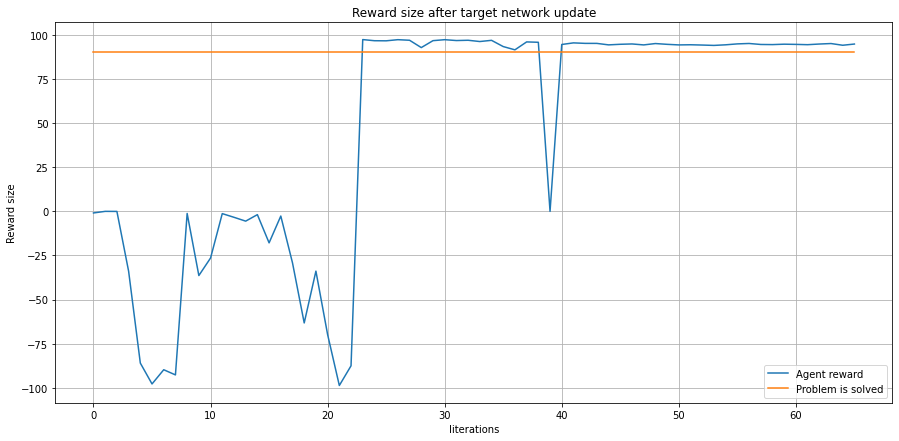

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Reward size after target network update')
plt.xlabel('Iiterations')
plt.ylabel('Reward size')
plt.grid()
plt.plot(np.arange(0, len(ac_policy.log_rewards)), ac_policy.log_rewards,
         label='Agent reward')
plt.plot(np.arange(0, len(ac_policy.log_rewards)), 
         [90] * len(ac_policy.log_rewards), label='Problem is solved')
plt.legend()
plt.show()

In [392]:
class ContiniousToDescret():
  def __init__(self, cont_pol, eps=0.0):
    self.cont_pol = cont_pol
    self.eps = eps

  def __call__(self, obs):
    act = self.cont_pol(obs)
    if abs(act) < self.eps:
      return 1
    return 0 if act < 0 else 2

In [ ]:
test_policy(env, 100, ContiniousToDescret(ac_policy))

mean: -143.63 
std: 28.638315243742955 
min: -200.0 
max: -85.0


Faster converge

In [ ]:
ac_policy = AC_policy()

In [ ]:
ac_policy.train(env2, 40, modify_reward=True, reward_modif_scale=100)

Episode 0 	reward: -2.397394164314146
Episode 1 	reward: -98.56463943915108
Episode 2 	reward: -99.4150934903582
Episode 3 	reward: -99.62085118821796
Episode 4 	reward: -99.590514158289
Episode 5 	reward: -99.65606992838238
Episode 6 	reward: -99.79374659883824
Episode 7 	reward: -99.79544884176936
Episode 8 	reward: -58.00627665625967
Episode 9 	reward: -81.42376225374468
Episode 10 	reward: -97.89287345944703
Episode 11 	reward: -98.40698141661451
Episode 12 	reward: -98.42534833791507
Episode 13 	reward: -97.82817102878776
Episode 14 	reward: -97.2825032236187
Episode 15 	reward: 78.1309221404951
Episode 16 	reward: 83.1963772259713
Episode 17 	reward: 84.16294059797207
Episode 18 	reward: 87.75662690772084
Episode 19 	reward: 88.4967971567172
Episode 20 	reward: 88.37886308440058
Episode 21 	reward: 93.60729191603947
Episode 22 	reward: 83.07890498881764
Episode 23 	reward: 93.38838951930144
Episode 24 	reward: 93.30415160617173
Episode 25 	reward: 93.26453512570833
Episode 26 	re

In [389]:
test_policy(env2, 100, ac_policy)

mean: 93.8146908876443 
std: 0.22653387440663275 
min: 93.41811840548833 
max: 94.16892191222821


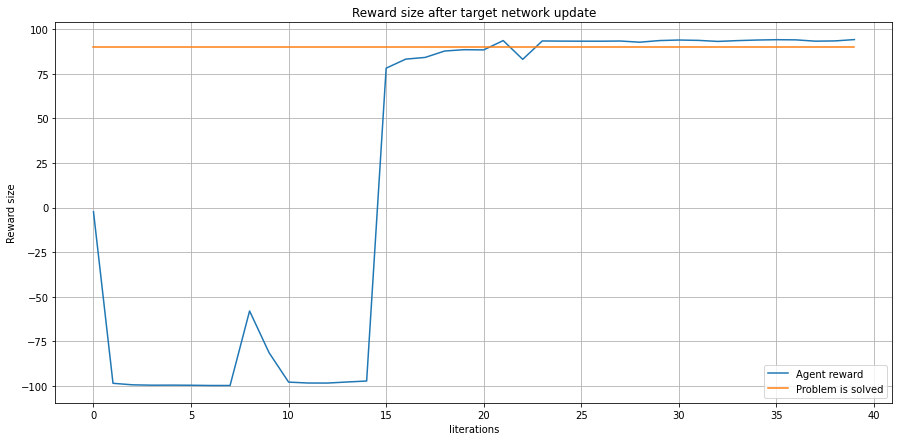

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Reward size after target network update')
plt.xlabel('Iiterations')
plt.ylabel('Reward size')
plt.grid()
plt.plot(np.arange(0, len(ac_policy.log_rewards)), ac_policy.log_rewards,
         label='Agent reward')
plt.plot(np.arange(0, len(ac_policy.log_rewards)), 
         [90] * len(ac_policy.log_rewards), label='Problem is solved')
plt.legend()
plt.show()

In [401]:
test_policy(env, 100, ContiniousToDescret(ac_policy, eps=0.05))

mean: -137.26 
std: 37.58659867559181 
min: -200.0 
max: -83.0


It is better to train new agent with Actor-Critic approach than try to adapt conitnious version to discrete manualy